# Characterizing the noise

## Method
<div style="text-align: justify;">
    
> To characterize the **image-domain response of the noise** in the visibility data, we performed imaging on a single realization constructed using the <code>SIGMA</code> array available in the Measurement Set.  
We then computed the one-dimensional spatial **power spectrum** <em>P(k)</em> of the resulting image.
>
> Note that to fully characterize <em>P(k)</em>, we recommend repeating this procedure over **multiple random realizations** (typically at least 20) and averaging the resulting spectra.

</div>

You can download the data directory ``ivis_data`` at XXX.

Kindly provided by Enrico Di Teodoro (UniFI) and Karlie Noon (RSAA/ANU).

### Read data

In [41]:
import glob
from tqdm import tqdm as tqdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from astropy.io import fits
from radio_beam import Beam
from astropy import units as u
from reproject import reproject_interp

from ivis.io import DataProcessor
from ivis.imager import Imager
from ivis.logger import logger
from ivis.utils import dutils, mod_loss, fourier

path_ms = "/Users/antoine/Desktop/ivis_data/msl_mw/" #directory of measurement sets    
path_beams = "/Users/antoine/Desktop/ivis_data/BEAMS/" #directory of primary beams
path_sd = None #path single-dish data
pathout = "/Users/antoine/Desktop/ivis_data/" #path where data will be packaged and stored

#REF WCS INPUT USER
filename = "/Users/antoine/Desktop/ivis_data_1beam/MW-C10_mom0th_NHI.fits"
target_header = fits.open(filename)[0].header
shape = (target_header["NAXIS2"],target_header["NAXIS1"])
    
#create data processor
data_processor = DataProcessor(path_ms, path_beams, path_sd, pathout)

# pre-compute pb and interpolation grids — this can be commented after first compute
logger.disabled = True
data_processor.compute_pb_and_grid(target_header, fitsname_pb="reproj_pb.fits", fitsname_grid="grid_interp.fits") 
logger.disabled = False

pb, grid = data_processor.read_pb_and_grid(fitsname_pb="reproj_pb.fits", fitsname_grid="grid_interp.fits")

#Dummy sd array
sd = np.zeros(shape)
#Dummy Beam sd
beam_sd = Beam(1*u.deg, 1*u.deg, 1.e-12*u.deg)

[2025-07-30 03:19:50 UTC] [IViS] [info] [Initialize DataProcessor ]
100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


In [42]:
#Read data
vis_data = data_processor.read_vis_from_scratch(uvmin=0, uvmax=np.inf,
                                                target_frequency=None,
                                                target_channel=0,
                                                extension=".ms",
                                                blocks='single',
                                                max_workers=1)

[2025-07-30 03:19:53 UTC] [IViS] [info] Processing single scheduling block.
[2025-07-30 03:19:53 UTC] [IViS] [info] Number of MS files = 5
[2025-07-30 03:19:53 UTC] [IViS] [info] Reading MS files with single thread.
[2025-07-30 03:19:53 UTC] [IViS] [info] Processing file 1/5: /Users/antoine/Desktop/ivis_data/msl_mw/MW-C10_1_MW_chan_-32kms.ms
[2025-07-30 03:19:54 UTC] [IViS] [info] Selected channel: 0 | Frequency: 1420557366.6050093 Hz | Velocity (LSRK): -32.0000000000517 km/s
[2025-07-30 03:19:54 UTC] [IViS] [info] Extracted 626313 valid baselines.
[2025-07-30 03:19:54 UTC] [IViS] [info] Time for iteration 1: 0.30s, ETA: 0.02 minutes
[2025-07-30 03:19:54 UTC] [IViS] [info] Processing file 2/5: /Users/antoine/Desktop/ivis_data/msl_mw/MW-C10_2_MW_chan_-32kms.ms
[2025-07-30 03:19:54 UTC] [IViS] [info] Selected channel: 0 | Frequency: 1420557366.6050096 Hz | Velocity (LSRK): -32.00000000010202 km/s
[2025-07-30 03:19:54 UTC] [IViS] [info] Extracted 1068720 valid baselines.
[2025-07-30 03:19

### Empty sky model

In [43]:
sky_model = np.zeros(shape, dtype=np.float32)

### Simulated visibilities (using IViS forward model)

In [44]:
#Model visibilities with IVis forward single frequency model
image_processor = Imager(vis_data,      # visibilities
                         pb,            # array of primary beams
                         grid,          # array of interpolation grids
                         None,            # single dish data in unit of Jy/arcsec^2
                         None,       # beam of single-dish data in radio_beam format
                         target_header, # header on which to image the data
                         sky_model,   # init array of parameters
                         0,       # maximum number of iterations
                         0,     # hyper-parameter single-dish
                         0,      # hyper-parameter regularization
                         False,    # impose a positivity constaint
                         0,        # device: 0 is GPU; "cpu" is CPU
                         beam_workers=1)

model_vis =  image_processor.forward_model()

[2025-07-30 03:19:55 UTC] [IViS] [info] [Initialize Imager        ]
[2025-07-30 03:19:55 UTC] [IViS] [info] Number of iterations to be performed by the optimizer: 0
[2025-07-30 03:19:55 UTC] [IViS] [warning] lambda_r = 0 - No spatial regularization.
[2025-07-30 03:19:55 UTC] [IViS] [warning] lambda_sd = 0 - No short spacing correction (ignoring single dish data).
[2025-07-30 03:19:55 UTC] [IViS] [warning] CUDA not available. Falling back on CPU.


### Adding realistic noise from the MeerKAT data beam

In [45]:
#Add noise
fact=1 #Scale the noise with this if needed
noise_real = np.random.normal(loc=0.0, scale=vis_data.sigma*fact)
noise_imag = np.random.normal(loc=0.0, scale=vis_data.sigma*fact)
noise = noise_real + 1j * noise_imag

# Add realistic thermal noise to the model visibilities
vis_data.data = model_vis + noise

### Imaging using IViS

In [46]:
#user parameters
max_its = 20
lambda_sd = 0 #not relevant here
lambda_r = 1 #Control the strength of the Lplacian filtering
device = 0#"cpu" #0 is GPU and "cpu" is CPU
positivity = False #Set to False because noise fluctuates around 0

#Initial parameters (zero array)
init_params = np.zeros(shape, dtype=np.float32)

#create image processor
image_processor = Imager(vis_data,      # visibilities
                         pb,            # array of primary beams
                         grid,          # array of interpolation grids
                         sd,            # single dish data in unit of Jy/arcsec^2
                         beam_sd,       # beam of single-dish data in radio_beam format
                         target_header, # header on which to image the data
                         init_params,   # init array of parameters
                         max_its,       # maximum number of iterations
                         lambda_sd,     # hyper-parameter single-dish
                         lambda_r,      # hyper-parameter regularization
                         positivity,    # impose a positivity constaint
                         device,        # device: 0 is GPU; "cpu" is CPU
                         beam_workers=1)
#get image
result = image_processor.process(units="Jy/arcsec^2") #"Jy/arcsec^2" or "K"

[2025-07-30 03:19:56 UTC] [IViS] [info] [Initialize Imager        ]
[2025-07-30 03:19:56 UTC] [IViS] [info] Number of iterations to be performed by the optimizer: 20
[2025-07-30 03:19:56 UTC] [IViS] [warning] lambda_sd = 0 - No short spacing correction (ignoring single dish data).
[2025-07-30 03:19:56 UTC] [IViS] [warning] CUDA not available. Falling back on CPU.
[2025-07-30 03:19:56 UTC] [IViS] [info] Starting optimisation (using LBFGS-B)
[2025-07-30 03:19:56 UTC] [IViS] [info] Optimizer not bounded - Positivity == False
[2025-07-30 03:20:01 UTC] [IViS] [info] [PID 83730] Total cost: 5.07223e+06
[2025-07-30 03:20:06 UTC] [IViS] [info] [PID 83730] Total cost: 1.77507e+09
[2025-07-30 03:20:07 UTC] [IViS] [info] [PID 83730] Total cost: 5.04979e+06
[2025-07-30 03:20:09 UTC] [IViS] [info] [PID 83730] Total cost: 5.03756e+06
[2025-07-30 03:20:10 UTC] [IViS] [info] [PID 83730] Total cost: 5.02982e+06
[2025-07-30 03:20:12 UTC] [IViS] [info] [PID 83730] Total cost: 5.02402e+06
[2025-07-30 03:2

In [47]:
#mean pb
filenames = sorted(glob.glob(path_beams+"*.fits"))
n_beams = len(filenames)
pb_all = np.zeros((n_beams,result.shape[0],result.shape[1]))
w = dutils.wcs2D(target_header)
for i in tqdm(np.arange(n_beams)):
    #open beam cube
    hdu_pb = fits.open(filenames[i])
    hdr_pb = hdu_pb[0].header
    pb2 = hdu_pb[0].data
    pb2[pb2 != pb2] = 0.
    w_pb = dutils.wcs2D(hdr_pb)
    pb2, footprint = reproject_interp((pb2,w_pb.to_header()), w.to_header(), shape)
    pb2[pb2 != pb2] = 0.
    pb_all += pb2
    pb_mean = np.nanmean(pb_all,0)
    pb_mean /= np.nanmax(pb_mean)    
    mask = np.where(pb_mean > 0.2, 1, np.nan)

100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


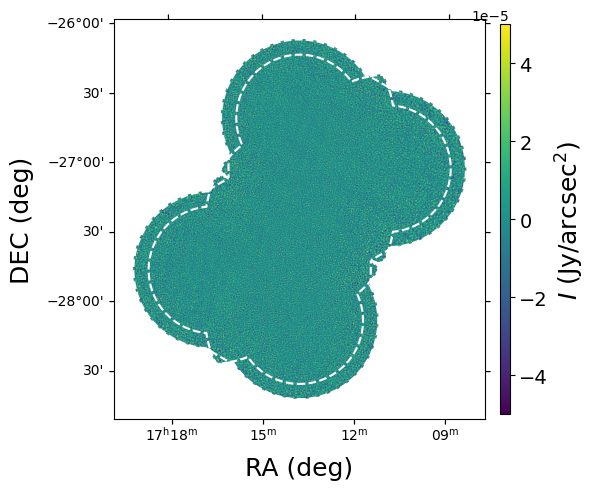

In [48]:
#PLOT RESULT
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"RA (deg)", fontsize=18.)
ax.set_ylabel(r"DEC (deg)", fontsize=18.)
img = ax.imshow(result*mask, vmin=-5e-5, vmax=5.e-5, origin="lower")
ax.contour(pb_mean, linestyles="--", levels=[0.2, 0.3], colors=["w","w"])
colorbar_ax = fig.add_axes([0.89, 0.11, 0.02, 0.78])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$I$ (Jy/arcsec$^{2})$", fontsize=18.)
#    plt.savefig(pathout + 'ivis_result_cloud_MeerKAT.png', format='png', bbox_inches='tight', pad_inches=0.02, dpi=400)

## Compute the P(k)

In [49]:
# Get tapper for apodization
tapper = fourier.apodize(0.97, shape)
# Reove the mean
field_zm = result - np.mean(result)
# Apply apodization function
field_zm_apod = field_zm * tapper

# Compute the 1D P(k)
ks, sps1d = fourier.powspec(field_zm_apod, reso=(target_header["CDELT2"]*u.deg).to(u.arcmin).value)

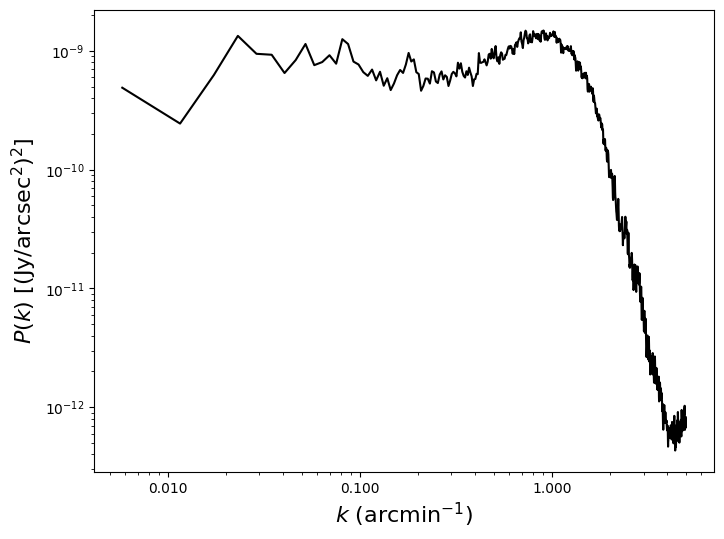

In [50]:
#Plot sps1D                                                                                                                                                                                                                                            
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')                                                                                                                                                                                                                                                                            
ax.plot(ks, sps1d, "-k")                                                                                                             
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$k$ (arcmin$^{-1}$)", fontsize = 16)
ax.set_ylabel(r"$P(k)$ [(Jy/arcsec$^2$)$^2$]", fontsize = 16)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#plt.savefig('plot/SPS_.png', format='png', bbox_inches='tight', pad_inches=0.02)